In [1]:
!nvidia-smi

Fri Mar  8 12:23:50 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:86:00.0 Off |                  Off |
| N/A   40C    P0    30W / 150W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import gc

def clear_gpu_memory(*args):
    """
    Clears specified PyTorch tensors or models from GPU memory, then clears the GPU memory cache.
    
    Args:
    *args: Variable length argument list. Expected to be PyTorch tensors or models.
    """
    # Attempt to delete each passed argument
    for arg in args:
        # Check if the argument is a tensor and is on GPU
        if isinstance(arg, torch.Tensor) and arg.is_cuda:
            # Delete the argument to release its GPU memory
            del arg
        # If it's a model or other structure with parameters
        elif hasattr(arg, 'parameters'):
            # Delete each parameter to release its GPU memory
            for param in arg.parameters():
                if param.is_cuda:
                    del param
    
    # Explicitly collect garbage
    gc.collect()
    
    # Empty the CUDA cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("GPU memory cache has been emptied.")


In [3]:
#import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer
from transformers import AutoTokenizer, pipeline, logging, AutoModelForCausalLM

from huggingface_hub import notebook_login
from datasets import Dataset
#imdb = load_dataset("parquet", data_files={'train': 'imdb/plain_text/train-00000-of-00001.parquet', 'test': 'imdb/plain_text/train-00000-of-00001.parquet'})
import pandas as pd
import transformers
import torch

from neel_plotly import line, imshow, scatter
import transformer_lens.patching as patching
# Load CSV file with pandas
#df = pd.read_csv('imdb/IMDB Dataset.csv', nrows=15000)
# Convert the DataFrame to a Hugging Face Dataset
#dataset = Dataset.from_pandas(df)
import circuitsvis as cv

In [4]:
def load_HookededTransformer(model_type):
    if model_type=='Llama-7b':
        model_name = "../Models/Llama-2-7b-hf"
        model_basename = model_type
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        hf_model = AutoModelForCausalLM.from_pretrained(model_name, low_cpu_mem_usage=True)

        for param in hf_model.parameters():
             param.requires_grad = False
        # Move the model to evaluation mode to disable dropout, batchnorm etc., which are not needed during inference
        hf_model.eval()
        model = HookedTransformer.from_pretrained("llama-7b", hf_model=hf_model, tokenizer= tokenizer, device="cuda", dtype="float16")
    elif model_type=='Mistral-7b':
        model_name = "../Models/Mistral-7B-v0.1"
        model_basename = "Mistral"
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        hf_model = AutoModelForCausalLM.from_pretrained(model_name, low_cpu_mem_usage=True)

        for param in hf_model.parameters():
             param.requires_grad = False
        # Move the model to evaluation mode to disable dropout, batchnorm etc., which are not needed during inference
        hf_model.eval()
        model = HookedTransformer.from_pretrained("llama-7b", hf_model=hf_model, tokenizer= tokenizer, device="cuda", dtype="float16")
    return model, tokenizer

In [5]:
torch.set_grad_enabled(False)
model, tokenizer = load_HookededTransformer(model_type='Llama-7b')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model llama-7b into HookedTransformer


In [6]:
llama_text = "Natural language processing tasks, such as question answering, machine translation, reading comprehension, and summarization, are typically approached with supervised learning on taskspecific datasets."
llama_tokens = model.to_tokens(llama_text)
llama_logits, llama_cache = model.run_with_cache(llama_tokens, remove_batch_dim=True)

attention_pattern = llama_cache["pattern", 0, "attn"]
llama_str_tokens = model.to_str_tokens(llama_text)

print("Layer 0 Head Attention Patterns:")
display(cv.attention.attention_patterns(tokens=llama_str_tokens, attention=attention_pattern))

Layer 0 Head Attention Patterns:


In [9]:
clear_gpu_memory(llama_logits, llama_cache)

GPU memory cache has been emptied.


In [11]:
prompts = ['When John and Mary went to the shops, John gave the bag to', 'When John and Mary went to the shops, Mary gave the bag to']
answers = [('Mary', 'John'), ('John', 'Mary')]

clean_tokens = model.to_tokens(prompts)
# Swap each adjacent pair, with a hacky list comprehension
corrupted_tokens = clean_tokens[
    [(i+1 if i%2==0 else i-1) for i in range(len(clean_tokens)) ]
    ]
print("Clean string 0", model.to_string(clean_tokens[0]))
print("Corrupted string 0", model.to_string(corrupted_tokens[0]))

answer_token_indices = torch.tensor([[model.to_single_token(answers[i][j]) for j in range(2)] for i in range(len(answers))], device=model.cfg.device)
print("Answer token indices", answer_token_indices)

Clean string 0 <s> When John and Mary went to the shops, John gave the bag to
Corrupted string 0 <s> When John and Mary went to the shops, Mary gave the bag to
Answer token indices tensor([[6182, 2259],
        [2259, 6182]], device='cuda:0')


In [12]:
def get_logit_diff(logits, answer_token_indices=answer_token_indices):
    if len(logits.shape)==3:
        # Get final logits only
        logits = logits[:, -1, :]
    correct_logits = logits.gather(1, answer_token_indices[:, 0].unsqueeze(1))
    incorrect_logits = logits.gather(1, answer_token_indices[:, 1].unsqueeze(1))
    return (correct_logits - incorrect_logits).mean()

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

clean_logit_diff = get_logit_diff(clean_logits, answer_token_indices).item()
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = get_logit_diff(corrupted_logits, answer_token_indices).item()
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")

Clean logit diff: 5.4727
Corrupted logit diff: -5.4727


In [13]:
CLEAN_BASELINE = clean_logit_diff
CORRUPTED_BASELINE = corrupted_logit_diff
def ioi_metric(logits, answer_token_indices=answer_token_indices):
    return (get_logit_diff(logits, answer_token_indices) - CORRUPTED_BASELINE) / (CLEAN_BASELINE  - CORRUPTED_BASELINE)

print(f"Clean Baseline is 1: {ioi_metric(clean_logits).item():.4f}")
print(f"Corrupted Baseline is 0: {ioi_metric(corrupted_logits).item():.4f}")

Clean Baseline is 1: 1.0000
Corrupted Baseline is 0: 0.0000


In [14]:
# Whether to do the runs by head and by position, which are much slower
DO_SLOW_RUNS = True

In [15]:
clear_gpu_memory()

GPU memory cache has been emptied.


In [ ]:
get_act_patch_resid_pre = partial(
    generic_activation_patch,
    patch_setter=layer_pos_patch_setter,
    activation_name="resid_pre",
    index_axis_names=("layer", "pos"),
)

In [71]:
patching_metric=ioi_metric
patch_setter=patching.layer_pos_patch_setter
activation_name="resid_pre"
index_axis_names=("layer", "pos")

max_axis_range = {
            "layer": model.cfg.n_layers,
            "pos": corrupted_tokens.shape[-1],
            "head_index": model.cfg.n_heads,
        }

max_axis_range["src_pos"] = max_axis_range["pos"]
max_axis_range["dest_pos"] = max_axis_range["pos"]
max_axis_range["head"] = max_axis_range["head_index"]

# Get the max range for each axis we iterate over
index_axis_max_range = [
    max_axis_range[axis_name] for axis_name in index_axis_names
]

        # Get the dataframe where each row is a tuple of indices
index_df = patching.make_df_from_ranges(index_axis_max_range, index_axis_names)

In [52]:
from tqdm import tqdm
from functools import partial


def patching_hook(corrupted_activation, hook, index, clean_activation):
        return patch_setter(corrupted_activation, index, clean_activation)

    # Iterate over every list of indices, and make the appropriate patch!
for c, index_row in enumerate(tqdm((list(index_df.iterrows())[0:1]))):
    index = index_row[1].to_list()
    current_activation_name = utils.get_act_name(activation_name, layer=index[0])
    current_hook = partial(
            patching_hook,
            index=index,
            clean_activation=clean_cache[current_activation_name],
        )
    patched_logits = model.run_with_hooks(
            corrupted_tokens, fwd_hooks=[(current_activation_name, current_hook)]
        )

100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


In [76]:
clear_gpu_memory(patched_logits)

GPU memory cache has been emptied.


In [75]:
patching_metric(patched_logits.to("cuda"))

tensor(0., device='cuda:0', dtype=torch.float16, grad_fn=<DivBackward0>)

In [ ]:
    if index_df is None:
        assert index_axis_names is not None

        # Get the max range for all possible axes
        max_axis_range = {
            "layer": model.cfg.n_layers,
            "pos": corrupted_tokens.shape[-1],
            "head_index": model.cfg.n_heads,
        }
        max_axis_range["src_pos"] = max_axis_range["pos"]
        max_axis_range["dest_pos"] = max_axis_range["pos"]
        max_axis_range["head"] = max_axis_range["head_index"]

        # Get the max range for each axis we iterate over
        index_axis_max_range = [
            max_axis_range[axis_name] for axis_name in index_axis_names
        ]

        # Get the dataframe where each row is a tuple of indices
        index_df = make_df_from_ranges(index_axis_max_range, index_axis_names)

        flattened_output = False

  0%|          | 0/512 [00:00<?, ?it/s]

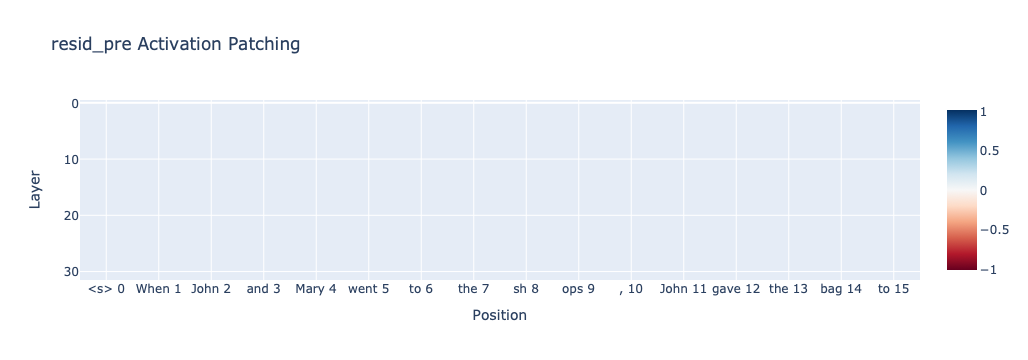

In [16]:
resid_pre_act_patch_results = patching.get_act_patch_resid_pre(model, corrupted_tokens, clean_cache, ioi_metric)
imshow(resid_pre_act_patch_results, 
       yaxis="Layer", 
       xaxis="Position", 
       x=[f"{tok} {i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))],
       title="resid_pre Activation Patching")

  0%|          | 0/1024 [00:00<?, ?it/s]

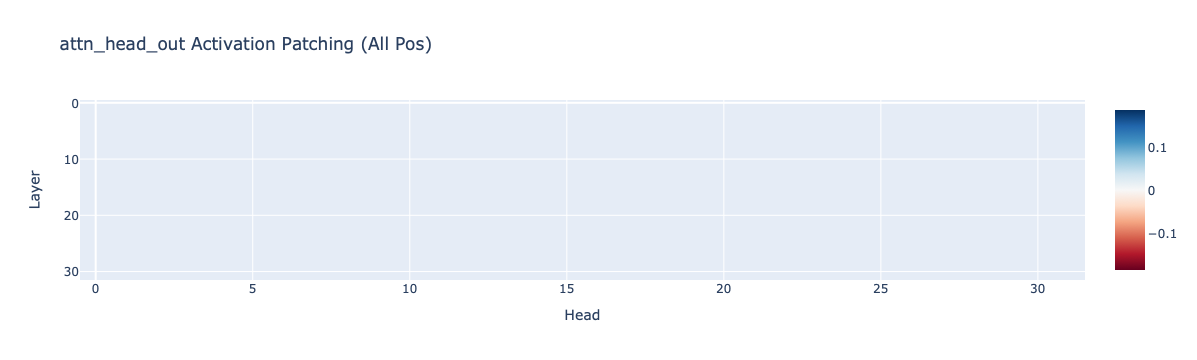

In [17]:
attn_head_out_all_pos_act_patch_results = patching.get_act_patch_attn_head_out_all_pos(model, corrupted_tokens, clean_cache, ioi_metric)
imshow(attn_head_out_all_pos_act_patch_results, 
       yaxis="Layer", 
       xaxis="Head", 
       title="attn_head_out Activation Patching (All Pos)")

In [18]:
ALL_HEAD_LABELS = [f"L{i}H{j}" for i in range(model.cfg.n_layers) for j in range(model.cfg.n_heads)]
if DO_SLOW_RUNS:
    attn_head_out_act_patch_results = patching.get_act_patch_attn_head_out_by_pos(model, corrupted_tokens, clean_cache, ioi_metric)
    attn_head_out_act_patch_results = einops.rearrange(attn_head_out_act_patch_results, "layer pos head -> (layer head) pos")
    imshow(attn_head_out_act_patch_results, 
        yaxis="Head Label", 
        xaxis="Pos", 
        x=[f"{tok} {i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))],
        y=ALL_HEAD_LABELS,
        title="attn_head_out Activation Patching By Pos")

  0%|          | 0/16384 [00:00<?, ?it/s]

NameError: name 'einops' is not defined

In [ ]:
every_block_result = patching.get_act_patch_block_every(model, corrupted_tokens, clean_cache, ioi_metric)
imshow(every_block_result, facet_col=0, facet_labels=["Residual Stream", "Attn Output", "MLP Output"], title="Activation Patching Per Block", xaxis="Position", yaxis="Layer", zmax=1, zmin=-1, x= [f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))])

In [ ]:
every_head_all_pos_act_patch_result = patching.get_act_patch_attn_head_all_pos_every(model, corrupted_tokens, clean_cache, ioi_metric)
imshow(every_head_all_pos_act_patch_result, facet_col=0, facet_labels=["Output", "Query", "Key", "Value", "Pattern"], title="Activation Patching Per Head (All Pos)", xaxis="Head", yaxis="Layer", zmax=1, zmin=-1)
# [markdown]
# We can also do by head *and* by position. This is a bit slow, but it can give useful + fine-grained detail

In [ ]:
if DO_SLOW_RUNS:
    every_head_act_patch_result = patching.get_act_patch_attn_head_by_pos_every(model, corrupted_tokens, clean_cache, ioi_metric)
    every_head_act_patch_result = einops.rearrange(every_head_act_patch_result, "act_type layer pos head -> act_type (layer head) pos")
    imshow(every_head_act_patch_result, facet_col=0, facet_labels=["Output", "Query", "Key", "Value", "Pattern"], title="Activation Patching Per Head (By Pos)", xaxis="Position", yaxis="Layer & Head", zmax=1, zmin=-1, x= [f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))], y=ALL_HEAD_LABELS)

In [ ]:
prompts = [
    "The capital of Germany is",
    "2 * 42 = ", 
    "My favorite", 
    "aosetuhaosuh aostud aoestuaoentsudhasuh aos tasat naostutshaosuhtnaoe usaho uaotsnhuaosntuhaosntu haouaoshat u saotheu saonuh aoesntuhaosut aosu thaosu thaoustaho usaothusaothuao sutao sutaotduaoetudet uaosthuao uaostuaoeu aostouhsaonh aosnthuaoscnuhaoshkbaoesnit haosuhaoe uasotehusntaosn.p.uo ksoentudhao ustahoeuaso usant.hsa otuhaotsi aostuhs",
]

model.eval()
hf_model.eval()
prompt_ids = [tokenizer.encode(prompt, return_tensors="pt") for prompt in prompts]
tl_logits = [model(prompt_id).detach().cpu() for prompt_id in tqdm(prompt_ids)]

# hf logits are really slow as it's on CPU. If you have a big/multi-GPU machine, run `hf_model = hf_model.to("cuda")` to speed this up
logits = [hf_model(prompt_id).logits.detach().cpu() for prompt_id in tqdm(prompt_ids)]

for i in range(len(prompts)): 
    assert torch.allclose(logits[i], tl_logits[i], atol=1e-4, rtol=1e-2)

In [ ]:
prompt = "Once upon a time"
input_ids = tokenizer(prompt, return_tensors="pt").input_ids

# Generate a sequence of tokens
output = hf_model.generate(input_ids, max_length=100)

# Decode the output tokens
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

print(generated_text)



In [ ]:
#model = HookedTransformer.from_pretrained('mistralai/Mistral-7B-v0.1', hf_model=hf_model)
model = HookedTransformer.from_pretrained("gpt2-small")

In [ ]:
'''
tokenizer = LlamaTokenizer.from_pretrained(LLAMA_2_7B_CHAT_PATH)
hf_model = LlamaForCausalLM.from_pretrained(LLAMA_2_7B_CHAT_PATH, low_cpu_mem_usage=True)

model = HookedTransformer.from_pretrained(LLAMA_2_7B_CHAT_PATH, device="cpu", fold_ln=False, center_writing_weights=False, center_unembed=False)

model = model.to("cuda" if torch.cuda.is_available() else "cpu")
model.generate("The capital of Germany is", max_new_tokens=20, temperature=0)
'''

In [ ]:
print("\n\n*** Generate:")

inputs = tokenizer.encode("What are you doing? give me the long answer", return_tensors="pt").to("cuda:0")
outputs = model.generate(input_ids=inputs)
print(tokenizer.decode(outputs[0]))

In [ ]:
outputs

In [ ]:
inputs

# Toy Example : text-generation

In [ ]:
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto",
)

prompt = 'I liked "Breaking Bad" and "Band of Brothers". Do you have any recommendations of other shows I might like?\n'
sequences = pipeline(
    prompt,
    do_sample=True,
    top_k=2,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    max_length=200,
)

print(f"Prompt: {prompt}")

for seq in sequences:
    print(f"Result: {seq['generated_text']}")

In [ ]:
pipeline = transformers.pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto",
)

prompt = 'I liked "Parasite" and "Okja". Do you have any recommendations of other shows I might like?\n'
sequences = pipeline(
    prompt,
    do_sample=True,
    top_k=2,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    max_length=200,
)

print(f"Prompt: {prompt}")

for seq in sequences:
    print(f"Result: {seq['generated_text']}")

# Toy Example : Cross-entropy loss

In [ ]:
prompt = 'I liked "Parasite" and "Okja". Do you have any recommendations of other shows I might like?\n'
input_ids = tokenizer.encode(prompt, return_tensors="pt").to("cuda")

model.eval()  # Set the model to evaluation mode

generated_ids = input_ids
cross_entropy_losses = []

with torch.no_grad():  # Disable gradient calculation for inference
    for _ in range(100):  # Assuming a max_length of 200
        outputs = model(input_ids=generated_ids)
        logits = outputs.logits
        
        # Get the logits for the last generated token
        next_token_logits = logits[:, -1, :]
        
        # Sample the next token using top_k sampling
        #filtered_logits = torch.topk(next_token_logits, k=2).values
        filtered_logits=next_token_logits
        probabilities = torch.nn.functional.softmax(filtered_logits, dim=-1)
        next_token = torch.multinomial(probabilities, num_samples=1)
        next_token = next_token.squeeze(0)
        
        # Calculate cross-entropy loss for the generated token
        loss = torch.nn.functional.cross_entropy(filtered_logits, next_token)
        cross_entropy_losses.append(loss.item())

        # Break the loop if EOS token is generated
        if next_token == tokenizer.eos_token_id:
            break

        # Prepare the next input_ids
        generated_ids = torch.cat((generated_ids, next_token.unsqueeze(0)), dim=1)

# Decode the generated ids to text
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

print(f"Result: {generated_text}")
print(f"Cross-Entropy Losses: {cross_entropy_losses}")

In [ ]:
del loss

In [ ]:
model

In [ ]:
dir(layer.self_attn), layer.self_attn.num_heads, layer.self_attn.head_dim

In [ ]:
activations={}

def get_activation(name):
    def hook(model, input, output):
        # Assuming output is a tuple where the first element contains attention outputs
        attention_output = output[0]  # Adjust this based on the actual output structure
        # Extract activations for the specified head (layer 2, head 4)
        activations[name] = attention_output  # Adjust indices as necessary
    return hook

In [ ]:
get_activation

In [ ]:
layer.self_attn.qkv_proj.qweight.shape

In [ ]:
!nvidia-smi

In [ ]:
layer_idx=0

model.eval()
layer = model.model.model.layers[1]  # Adjust index for layer 2
hook_handles = []

handle = layer.self_attn.qkv_proj.register_forward_hook(get_activation('layer_2'))
hook_handles.append(handle)

# Example input to the model
input_ids = tokenizer.encode("Example input text here Example input input input input input text here Example input text here", return_tensors="pt").to("cuda")

# Perform a forward pass (ensure the input is appropriate for your model)
output = model(input_ids=input_ids)
attention_activations = activations['layer_2'].cpu()


In [ ]:
12288/3
n_head=32
n_layer=32


In [ ]:
attention_activations

In [ ]:
xq=attention_activations[:,n_head*n_layer*0:n_head*n_layer*1]
xk=attention_activations[:,n_head*n_layer*1:n_head*n_layer*2]
xv=attention_activations[:,n_head*n_layer*2:n_head*n_layer*3]


In [ ]:
k